<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/J_Carter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & Import

In [1]:
!pip install eagleSqlTools
!pip install colossus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 4.8 MB/s 


In [29]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
from colossus.cosmology import cosmology
from colossus.lss import mass_function

con = sql.connect("vwg533", password = "FZtn087h")

# Plot 1 Queries

In [3]:
sim_name = 'RefL0100N1504'
sim_size = 100.
    
# Construct and execute query for each simulation. This query returns the number of galaxies 
# for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
Query_1 = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_2 = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            (AP.Mass_BH/AP.Mass_Star) as ratio \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < 3.1622776601684e10 and \
            AP.Mass_Star > 1.0e10 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_blue = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            (AP.SFR/AP.Mass_Star) > 5.0e-12 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_red = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            (AP.SFR/AP.Mass_Star) < 5.0e-12 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

# Execute queries.
Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
Data_blue = sql.execute_query(con, Query_blue)
Data_red = sql.execute_query(con, Query_red)

In [4]:
# Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

In [5]:
# Splits data into 2 separate arrays for red & blue sequences
def redblue_split(d, ssfr, split):
  red = []
  blue = []
  for i in range(len(d)):
    if ssfr[i] < split:
      red = red + [d[i]]
    else:
      blue = blue + [d[i]]
  red_a = np.array(red)
  blue_a = np.array(blue)
  return red_a, blue_a

In [6]:
# Returns median y values within bins of size 'step' to make a line of "best fit"
def medians(xs, ys, min, max, step):
  xvals = np.arange(min, max+step, step)
  meds = np.empty(len(xvals))
  for i in range(len(meds)):
    yvals = ys[np.logical_and(xs > xvals[i], xs < (xvals[i]+step))]
    meds[i] = np.median(yvals)
  return xvals + step/2, meds

In [7]:
rmeds = medians(Data_red['mass'], Data_red['u_minus_r'], 9, 11, 0.2)
bmeds = medians(Data_blue['mass'], Data_blue['u_minus_r'], 9, 10.5, 0.25)

# Plot 1

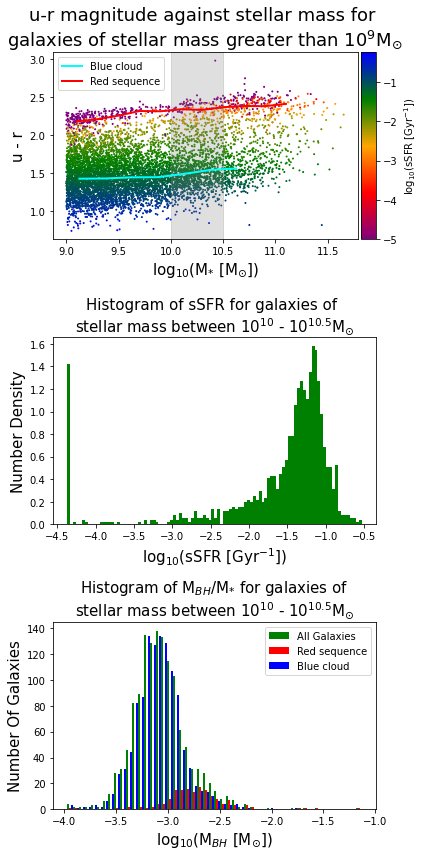

In [8]:
#cmap = plt.cm.gist_stern_r
#'''
cvals = [-2., -1, 0, 1, 2]
colors = ["purple","red","orange","green","blue"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
#'''

sSFR_1 = Data_1['ssfr']*10**9
LsSFR_1 = log_with_zeros(sSFR_1)
sSFR_2 = Data_2['ssfr']*10**9
LsSFR_2 = log_with_zeros(sSFR_2)
LRatio = log_with_zeros(Data_2['ratio'])
RB = redblue_split(LRatio, Data_2['ssfr'], 5.0e-12)
LRatio_r = RB[0]
LRatio_b = RB[1]
Lratios = np.array([LRatio, LRatio_r, LRatio_b], dtype = object)
Labels = ['All Galaxies', 'Red sequence', 'Blue cloud']

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (6,12))
im1 = ax1.scatter(Data_1['mass'], Data_1['u_minus_r'], s=1, c = LsSFR_1, cmap = cmap)
im2 = ax2.hist(LsSFR_2, bins = 100, density = True, rwidth = 1.0, color = 'g')
im3 = ax3.hist(Lratios, bins = 50, density = False, rwidth = 1.0, color = ['g','r','b'], label = Labels)
ax1.axvspan(10, 10.5, color='grey', alpha=0.25)

ax1.plot(bmeds[0], bmeds[1], linewidth = 2, color = 'cyan', label = 'Blue cloud')
ax1.plot(rmeds[0], rmeds[1], linewidth = 2, color = 'red', label = 'Red sequence')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log$_{10}$(sSFR [Gyr$^{-1}$])')

ax1.set_title('u-r magnitude against stellar mass for \n' + r'galaxies of stellar mass greater than 10$^{9}$M$_{\odot}$', fontsize=18)
ax2.set_title('Histogram of sSFR for galaxies of \n' + r'stellar mass between 10$^{10}$ - 10$^{10.5}$M$_{\odot}$', fontsize=15)
ax3.set_title('Histogram of M$_{BH}$/M$_{*}$ for galaxies of \n' + r'stellar mass between 10$^{10}$ - 10$^{10.5}$M$_{\odot}$', fontsize=15)
ax1.set_xlabel(r'log$_{10}$(M$_{*}$ [M$_{\odot}$])', fontsize=15)
ax1.set_ylabel(r'u - r', fontsize=15)
ax2.set_xlabel(r'log$_{10}$(sSFR [Gyr$^{-1}$])', fontsize=15)
ax2.set_ylabel(r'Number Density', fontsize=15)
ax3.set_xlabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)
ax3.set_ylabel(r'Number Of Galaxies', fontsize=15)
ax1.legend()
ax3.legend()

plt.tight_layout()
plt.savefig('Plot_1.jpeg')
plt.show()

# Plot 2 Queries

In [9]:
sim_name = 'RefL0100N1504'
sim_size = 100.

Query_IDs = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            log10(SH.MassType_DM) as halo, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            SH.GalaxyID as id \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Data_IDs = sql.execute_query(con, Query_IDs)

In [10]:
for i in range(len(Data_IDs['id'])):
  print('ID:' ,Data_IDs['id'][i])
  print('u-r:' ,Data_IDs['u_minus_r'][i])
  print('Stellar Mass:' ,Data_IDs['mass'][i])
  print('Halo Mass:' ,Data_IDs['halo'][i])
  print('sSFR:' ,Data_IDs['ssfr'][i])
  print('')

Streaming output truncated to the last 5000 lines.
sSFR: 3.1117796e-11

ID: 3411081
u-r: 1.6058731
Stellar Mass: 9.778220435511333
Halo Mass: 11.14042567720643
sSFR: 4.6596674e-11

ID: 3425636
u-r: 2.0118752
Stellar Mass: 9.967712461806137
Halo Mass: 11.094742672953544
sSFR: 1.6680747e-11

ID: 16094954
u-r: 2.3789558
Stellar Mass: 10.818506606860275
Halo Mass: 12.645324227845876
sSFR: 2.2221086e-12

ID: 16106437
u-r: 2.3115005
Stellar Mass: 10.504936377992394
Halo Mass: 12.742391244400137
sSFR: 3.6203598e-13

ID: 16424324
u-r: 2.3326836
Stellar Mass: 10.615519342409515
Halo Mass: 12.642834976733804
sSFR: 1.6004995e-12

ID: 16447237
u-r: 1.7415276
Stellar Mass: 10.851005365432375
Halo Mass: 12.53452629341427
sSFR: 3.305591e-11

ID: 4074412
u-r: 1.5513744
Stellar Mass: 9.2218165175159
Halo Mass: 11.074118343393422
sSFR: 4.490404e-11

ID: 4167517
u-r: 1.6735258
Stellar Mass: 9.070534459825991
Halo Mass: 10.9854192548361
sSFR: 3.1033776e-11

ID: 4248592
u-r: 2.3319626
Stellar Mass: 9.63138

In [11]:
sim_name = 'RefL0100N1504'
sim_size = 100.
galaxy_id_1 = 13259036 #17360562 # Red
galaxy_id_2 = 16956975 # Blue

# Red
Query_1 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_DM as halo, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_1)

# Blue
Query_2 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_DM as halo, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_2)

Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
r = len(Data_1['z'])
b = len(Data_2['z'])

In [12]:
def log_with_zeros(data): # Replaces zeroes with the smallest nonzero value.
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

def remove_zeros(data):
  out = []
  for i in range(len(data)):
    if data[i] == 0:
      out = out
    else:
      out = out + [data[i]]
  return np.array(out)

In [13]:
Times = np.array([13.62, 13.53, 13.32, 13.25, 13.16, 13.04, 12.86, 12.75, 12.63, 12.46, 12.25, 12.01, 11.66, 11.16,
                  10.86, 10.53, 10.05, 9.49, 8.86, 7.93, 7.37, 6.71, 6.01, 5.19, 4.16, 3.23, 2.29, 1.24, 0.0]) # len = 29

In [14]:
sSFR_1 = divide_with_zeros(Data_1['sfr'], Data_1['mass']) * 10**9

r_snapnums = np.arange(29-len(Data_1['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_1['mass'])
r_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, r_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  r_medians = r_medians + [np.median(Galaxies['ssfr'])]
r_medians = np.array(r_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum snapnum of merger tree /Gyr^-1
print(r_medians)

[1.89147031e-02 2.36605492e-02 2.95559688e-02 3.32599989e-02
 4.31635873e-02 5.41421283e-02 6.14232276e-02 6.86903173e-02
 7.10880382e-02 1.11416779e-01 1.65383596e-01 2.07322978e-01
 2.90164920e-01 3.63450270e-01 4.27312907e-01 6.45907772e-01
 1.22096178e+00 3.03207948e+00 3.31016192e+00 3.80973875e+00
 3.64706931e+00 3.82193743e+00 4.58013627e+00 3.94877819e+00
 4.45135395e+00 5.81408255e+00 3.36425865e+00 3.78233764e+01]


In [15]:
sSFR_2 = divide_with_zeros(Data_2['sfr'], Data_2['mass']) * 10**9

b_snapnums = np.arange(29-len(Data_2['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_2['mass'])
b_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, b_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  b_medians = b_medians + [np.median(Galaxies['ssfr'])]
b_medians = np.array(b_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum snapnum of merger tree /Gyr^-1
print(b_medians)

[ 0.02405771  0.02572934  0.04732992  0.07231762  0.08528357  0.11577372
  0.14120793  0.17768065  0.21430449  0.25909075  0.33677899  0.5695221
  0.85839791  1.00210251  1.14185983  1.33379496  1.73380477  2.20429985
  2.42302467  2.42209164  2.69788814  2.62317568  2.93983859  2.90645708
  3.18581139  3.13368798  2.60194954 19.12739833]


In [16]:
r_diffs = log_with_zeros(sSFR_1) - log_with_zeros(r_medians)
print(r_diffs)

b_diffs = log_with_zeros(sSFR_2) - log_with_zeros(b_medians)
print(b_diffs)

[-1.67403529 -1.77126059 -0.80284571 -1.03837619 -0.98294369 -0.74344344
 -0.40736108 -0.62369021 -1.13400418 -1.22006019 -0.37128378 -0.14984859
  0.28167187  0.37359682  0.38003956  0.33741953  0.33006526 -0.09269862
 -0.0501885  -0.24091192 -0.16615166  0.03507458  0.00736499  0.20044738
 -0.00976189 -0.18965986  0.82147502 -4.97499606]
[ 0.32542091  0.33741609  0.34849894  0.28712833  0.20766614 -0.01316262
 -0.13540958 -0.18878199 -0.20750871 -0.18523656 -0.11804871  0.06939968
 -0.01818214  0.03998023  0.08663971  0.07665759  0.0307487   0.31981959
 -0.31830769 -0.03819816 -0.3652581   0.291878    0.13509114  0.22223687
 -0.62474203  0.33641562 -0.85012836 -2.57498072]


# Plot 2

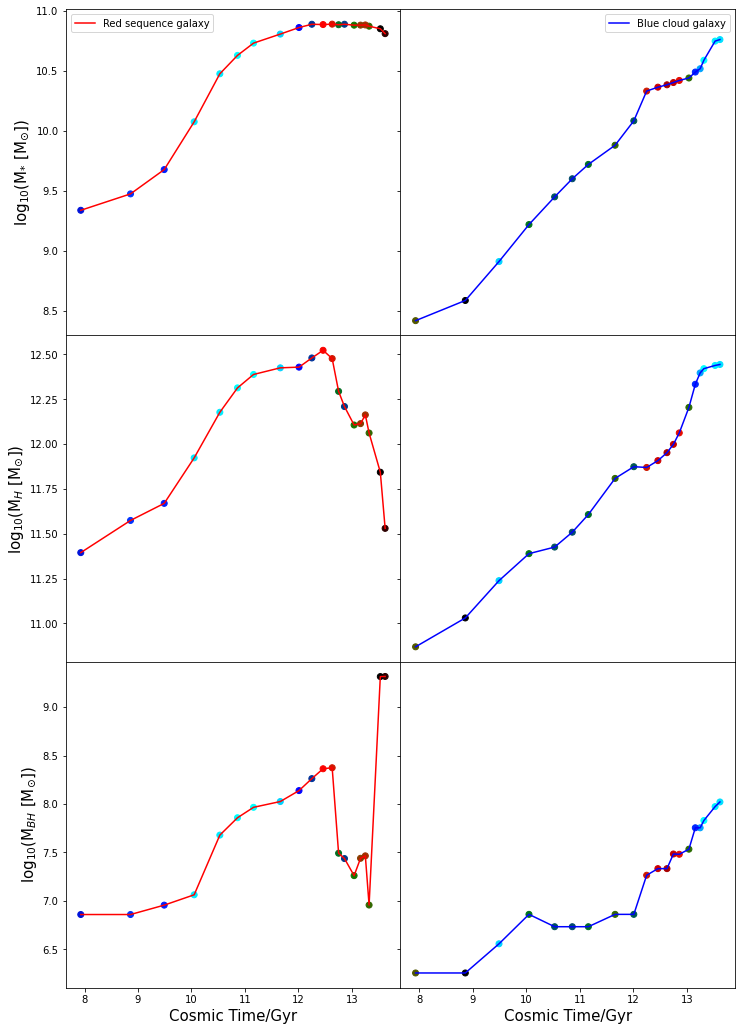

In [17]:
cvals = [-2, -1, 0, 1, 2]
colors = ["black","red","green","blue","cyan"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)

final = 8
r_Times = Times[0:r-final]
b_Times = Times[0:b-final]

bh_red = remove_zeros(Data_1['bh'])
bh_blue = remove_zeros(Data_2['bh'])
r2 = len(bh_red) - len(Times[0:r-final])
b2 = len(bh_blue) - len(Times[0:b-final])

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize = (12,18), sharex = True, sharey = 'row')

# z=0
ax1[0].plot(r_Times, log_with_zeros(Data_1['mass'])[0:-final], color = 'r', label = 'Red sequence galaxy')
ax1[1].plot(b_Times, log_with_zeros(Data_2['mass'])[0:-final], color = 'b', label = 'Blue cloud galaxy')
ax2[0].plot(r_Times, log_with_zeros(Data_1['halo'])[0:-final], color = 'r')
ax2[1].plot(b_Times, log_with_zeros(Data_2['halo'])[0:-final], color = 'b')
ax3[0].plot(r_Times, log_with_zeros(bh_red)[0:-r2], color = 'r')
ax3[1].plot(b_Times, log_with_zeros(bh_blue)[0:-b2], color = 'b')

ax1[0].scatter(r_Times, log_with_zeros(Data_1['mass'])[0:-final], c = r_diffs[0:-final], cmap = cmap)
ax1[1].scatter(b_Times, log_with_zeros(Data_2['mass'])[0:-final], c = b_diffs[0:-final], cmap = cmap)
ax2[0].scatter(r_Times, log_with_zeros(Data_1['halo'])[0:-final], c = r_diffs[0:-final], cmap = cmap)
ax2[1].scatter(b_Times, log_with_zeros(Data_2['halo'])[0:-final], c = b_diffs[0:-final], cmap = cmap)
ax3[0].scatter(r_Times, log_with_zeros(bh_red)[0:-r2], c = r_diffs[0:-final], cmap = cmap)
ax3[1].scatter(b_Times, log_with_zeros(bh_blue)[0:-b2], c = b_diffs[0:-final], cmap = cmap)

ax3[0].set_xlabel(r'Cosmic Time/Gyr', fontsize=15)
ax3[1].set_xlabel(r'Cosmic Time/Gyr', fontsize=15)
ax1[0].set_ylabel(r'log$_{10}$(M$_{*}$ [M$_{\odot}$])', fontsize=15)
ax2[0].set_ylabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax3[0].set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)
plt.subplots_adjust(hspace=.0, wspace=.0)
ax1[0].legend()
ax1[1].legend()
plt.savefig('Plot_2.jpeg')
plt.show()

# Plot 3 Queries

In [18]:
sim_name = 'RefL0100N1504'
sim_size = 100.
snapnums = [28, 19, 15, 10]
Results  = {}

for snapnum in snapnums:
    query = "SELECT \
              FOF.Group_M_Crit200 as m200, \
              SH.BlackHoleMass as bh, \
              SH.StarFormationRate as sfr, \
              SH.MassType_Star as star \
            FROM \
              %s_FOF as FOF, \
              %s_SubHalo as SH \
            WHERE \
              SH.SnapNum = %d and \
              SH.SubGroupNumber = 0 and \
              SH.MassType_Star > 0 and \
              FOF.Group_M_Crit200 > 1e10 and \
              SH.GroupID = FOF.GroupID" %(sim_name, sim_name, snapnum)
    Results[snapnum] = sql.execute_query(con, query)

In [19]:
#Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

# Returns median x and y values within bins of size 'step' to make a line of "best fit"
def medians(xs, ys, min, max, step):
  xbins = np.arange(min, max+step, step)
  xmeds = np.empty(len(xbins))
  ymeds = np.empty(len(xbins))
  for i in range(len(ymeds)):
    yvals = ys[np.logical_and(xs > xbins[i], xs < (xbins[i]+step))]
    ymeds[i] = np.median(yvals)
    xvals = xs[np.logical_and(xs > xbins[i], xs < (xbins[i]+step))]
    xmeds[i] = np.median(xvals)
  return xmeds, ymeds

# Removes element from both arrays if one/both of them is zero
def remove_zeros_2(data1, data2):
  out_1 = []
  out_2 = []
  for i in range(len(data1)):
    if data1[i] == 0:
      out_1 = out_1
      out_2 = out_2
    elif data2[i] == 0:
      out_1 = out_1
      out_2 = out_2
    else:
      out_1 = out_1 + [data1[i]]
      out_2 = out_2 + [data2[i]]
  return np.array(out_1), np.array(out_2)

# Divides two arrays, but replaces #/0 with 0
def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

# Plot 3

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


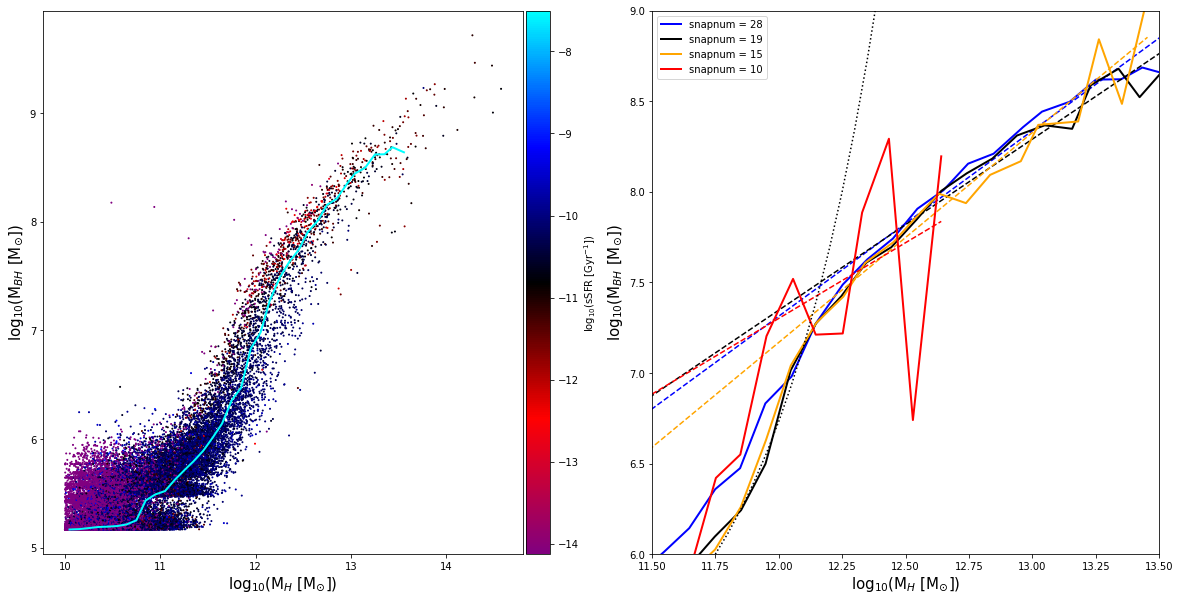

In [20]:
colours = ['blue', 'black', 'orange', 'red']

cvals = [-2, -1 , 0, 1 , 2]
colors = ["purple","red","black","blue","cyan"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)

sSFR1 = divide_with_zeros(Results[28]['sfr'], Results[28]['star'])
log_sSFR1 = log_with_zeros(sSFR1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))

im1 = ax1.scatter(log_with_zeros(Results[28]['m200']), log_with_zeros(Results[28]['bh']), c=log_sSFR1, cmap=cmap, s=1)
meds1 = medians(log_with_zeros(Results[28]['m200']), log_with_zeros(Results[28]['bh']), 10, 13.5, 0.1)
x1 = meds1[0]
y1 = meds1[1]
ax1.plot(x1, y1, linewidth=2, color='cyan')

ax1.set_xlabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax1.set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log$_{10}$(sSFR [Gyr$^{-1}$])')

for snapnum, colour in zip(snapnums, colours):
  meds = medians(log_with_zeros(Results[snapnum]['m200']), log_with_zeros(Results[snapnum]['bh']), 10, 13.5, 0.1)
  x = meds[0]
  y = meds[1]
  ax2.plot(x, y, linewidth=2, color=colour, label="snapnum = {0:2d}".format(snapnum))
  xl = x[np.logical_and(x > 12.25, x < 13.5)]
  yl = y[np.logical_and(x > 12.25, x < 13.5)]
  params = np.polyfit(xl, yl, 1)
  ax2.plot(x, params[0]*x + params[1], linestyle='dashed', color=colour)

xs1 = np.arange(11.5, 12.5, 0.05)
ys1 = 9**(xs1-11.75) + 5
ax2.plot(xs1, ys1, color='black', linestyle='dotted')

ax2.set_xlabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax2.set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)
ax2.set_xlim(11.5, 13.5)
ax2.set_ylim(6, 9)
ax2.legend()

plt.savefig('Plot_3.jpeg')
plt.show()

# Plot 4 Queries

In [21]:
sim_name = 'RefL0100N1504'
sim_size = 100.
zs = []
halos = []
bhs = []
sfrs = []

# For snapnums 28, 26, 23, 19, 14 ==> z = 0.0, 2.29, 5.19, 7.93, 10.86
galaxy_ids = [21573586, 21379523, 21730540, 13259036, 21109774]


for i in range(len(galaxy_ids)):
  Query = "SELECT \
              gal.Redshift as z, \
              gal.MassType_DM as halo, \
              gal.MassType_BH as bh, \
              gal.StarFormationRate as sfr \
            FROM \
              %s_Subhalo as gal, \
              %s_Subhalo as ref \
            WHERE \
              ref.GalaxyID=%s and \
              ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
              between gal.GalaxyID and gal.TopLeafID) or \
              (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
              between ref.GalaxyID and ref.TopLeafID)) \
            ORDER BY \
              gal.Redshift"%(sim_name, sim_name, galaxy_ids[i])

  Data = sql.execute_query(con, Query)
  zs.append(Data['z'])
  halos.append(Data['halo'])
  bhs.append(Data['bh'])
  sfrs.append(Data['sfr'])

In [22]:
def log_with_zeros(data): # Replaces zeroes with the smallest nonzero value.
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

def remove_zeros(data):
  out = []
  for i in range(len(data)):
    if data[i] == 0:
      out = out
    else:
      out = out + [data[i]]
  return np.array(out)

In [23]:
Times = np.array([13.62, 13.53, 13.32, 13.25, 13.16, 13.04, 12.86, 12.75, 12.63, 12.46, 12.25, 12.01, 11.66, 11.16,
                  10.86, 10.53, 10.05, 9.49, 8.86, 7.93, 7.37, 6.71, 6.01, 5.19, 4.16, 3.23, 2.29, 1.24, 0.0]) # len = 29

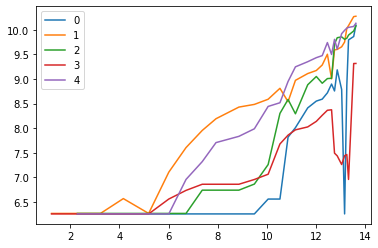

In [24]:
plt.figure()

for i in range(len(bhs)):
  d = 29 - len(bhs[i])
  plt.plot(Times[0:-d], log_with_zeros(bhs[i]), label = i)

plt.legend()
plt.show()

In [25]:
Start_times = np.array([10.53, 5.19, 9.49, 10.05, 6.01])

In [26]:
Corrected = []

for i in range(len(Start_times)):
  c = Times - Start_times[i]
  Corrected.append(c)

# Plot 4

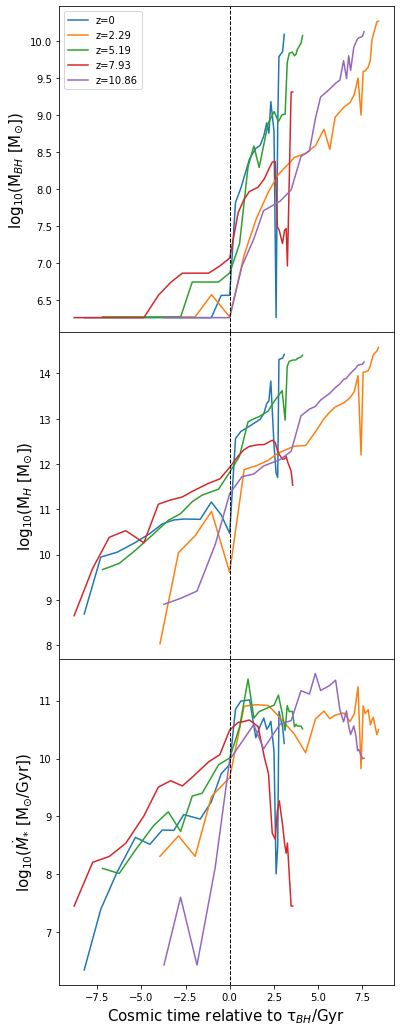

In [27]:
redshifts = [0, 2.29, 5.19, 7.93, 10.86]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6,18), sharex = True)

for i in range(len(bhs)):
  d = 29 - len(bhs[i])
  ax1.plot(Corrected[i][0:-d], log_with_zeros(bhs[i]), label = 'z=%s'%(redshifts[i]))

for i in range(len(bhs)):
  d = 29 - len(bhs[i])
  ax2.plot(Corrected[i][0:-d], log_with_zeros(halos[i]), label = 'z=%s'%(redshifts[i]))

for i in range(len(bhs)):
  d = 29 - len(bhs[i])
  ax3.plot(Corrected[i][0:-d], log_with_zeros(sfrs[i]*1e9), label = 'z=%s'%(redshifts[i]))

ax1.legend()
ax1.axvline(0, color='black', linestyle='--', linewidth=1)
ax2.axvline(0, color='black', linestyle='--', linewidth=1)
ax3.axvline(0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Cosmic time relative to \u03C4$_{BH}$/Gyr', fontsize=15)
ax1.set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)
ax2.set_ylabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax3.set_ylabel(r'log$_{10}$($\dot{M}$$_{*}$ [M$_{\odot}$/Gyr])', fontsize=15)
plt.subplots_adjust(hspace=.0)

plt.savefig('Plot_4.jpeg')
plt.show()

# Mass Function

In [30]:
cosmology.setCosmology('WMAP9')
# mfunc_fof = mass_function.massFunction(1E12, 0.0, mdef = 'fof', model = 'watson13')

In [31]:
powers = np.arange(12.,15.1, 0.1)
masses = 10**powers
mfunc = []

for i in range (len(masses)):
  mfunc = mfunc + [mass_function.massFunction(masses[i], 0.1, mdef = 'fof', model = 'watson13')]# mdef = 'vir', model = 'tinker08')]

In [32]:
sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2

Query = "SELECT \
          0.1+floor(log10(FOF.Group_M_Crit200)/%s)*%s as mass, \
          count(*) as num \
        FROM \
          %s_SubHalo as SH, \
          %s_FOF as FOF \
        WHERE \
          SH.SnapNum = 27 and \
          SH.GroupID = FOF.GroupID and \
          FOF.Group_M_Crit200 > 1e12 \
        GROUP BY \
          0.1+floor(log10(FOF.Group_M_Crit200)/%s)*%s \
        ORDER BY \
          mass"%(bin_width, bin_width, sim_name, sim_name, bin_width, bin_width)

Results = sql.execute_query(con, Query)

In [33]:
sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2

Query = "SELECT \
          0.1+floor(log10(AP.Mass_DM)/%s)*%s as mass, \
          count(*) as num \
        FROM \
          %s_SubHalo as SH, \
          %s_Aperture as AP \
        WHERE \
          SH.GalaxyID = AP.GalaxyID and \
          AP.Mass_DM > 1e12 and \
          SH.SnapNum = 27 \
        GROUP BY \
          0.1+floor(log10(AP.Mass_DM)/%s)*%s \
        ORDER BY \
          mass"%(bin_width, bin_width, sim_name, sim_name, bin_width, bin_width)

Results = sql.execute_query(con, Query)

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2

Query = "SELECT \
          0.1+floor(log10(SH.MassType_DM)/%s)*%s as mass, \
          count(*) as num \
        FROM \
          %s_SubHalo as SH \
        WHERE \
          SH.SnapNum = 27 and \
          SH.MassType_DM > 1e12 \
        GROUP BY \
          0.1+floor(log10(SH.MassType_DM)/%s)*%s \
        ORDER BY \
          mass"%(bin_width, bin_width, sim_name, bin_width, bin_width)

Results = sql.execute_query(con, Query)

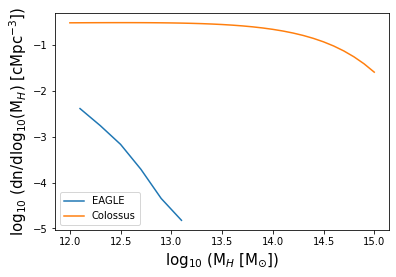

In [34]:
hist = Results['num'][:] / float(sim_size)**3.
hist = hist / bin_width

plt.figure()

plt.plot(Results['mass'], np.log10(hist), label='EAGLE')

plt.plot(np.log10(masses), np.log10(mfunc), label='Colossus')

plt.xlabel(r'log$_{10}$ (M$_{H}$ [M$_{\odot}$])', fontsize=15)
plt.ylabel(r'log$_{10}$ (dn/dlog$_{10}$(M$_{H}$) [cMpc$^{-3}$])', fontsize=15)
plt.legend()

plt.savefig('Plot_5.jpeg')
plt.show()